In [1]:

import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import matplotlib.animation as animation
import matplotlib.colors as colors
import animatplot as amp
import numpy as np
import pandas as pd
import feltorutilities as fp
import magneticfielddb as mag
import simplesimdb as simplesim
import xarray as xr
import xfeltor
import time
import cm_xml_to_matplotlib as cm

# plt.rcParams.update({'font.size': 22})

In [2]:
data = simplesim.Manager( directory="./resistivity-scan-data", filetype="nc")
diag = simplesim.Manager( executable="./feltordiag.sh", directory="resistivity-scan-diag", filetype="nc")

In [3]:
content = data.table()
print( f"The database contains {np.size(content)} simulations")
i = 0
for file in content:
    
    print( data.outfile( file), " split into ", data.count( file), " file(s)", i)
    i+=1

The database contains 6 simulations
./resistivity-scan-data/09921d0de3af7a8e467b2cb72e70bcc1d355799b.nc  split into  10  file(s) 0
./resistivity-scan-data/33752dd60b65c471ded739466e3f196ad1c410d9.nc  split into  10  file(s) 1
./resistivity-scan-data/8018809091944c0999b258c85eab09171a919ff2.nc  split into  10  file(s) 2
./resistivity-scan-data/922c17c817a756e4632e15bc86464abc60f45628.nc  split into  10  file(s) 3
./resistivity-scan-data/c857bb29fb57ca1f7f563fd16dc9c26afc644f18.nc  split into  10  file(s) 4
./resistivity-scan-data/f861b2031ceca72b26ede2111cd19b65626da364.nc  split into  10  file(s) 5


In [4]:
def create_merged_dataset( manager, file ) :
    datasetpaths = [manager.outfile(file,i) for i in range(manager.count(file))]
    return xfeltor.open_feltordataset( datasetpaths)


In [5]:
 # Temporary easy work with only one list element
full_content = diag.table()
content = []
content.append( full_content[0])
content.append( full_content[1])
content.append( full_content[2])
content.append( full_content[3])
content.append( full_content[4])
content.append( full_content[5])

In [6]:
# for file in content :
file = content[1]
da = create_merged_dataset( data, file)
ds = create_merged_dataset( diag, file)
print( da.physical["resistivity"])
lvls=da.boundary["wall"]["boundary"]
print( "Wall levels = ", lvls)

/home/matthias/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


0.0001
Wall levels =  [1.15, 0.97]


In [7]:
Z = da['yc'][0,0,:,:]
rhop = da['Rho_p'][0,:,:]
Z

<xarray.DataArray 'yc' (y: 504, x: 288)>
dask.array<getitem, shape=(504, 288), dtype=float64, chunksize=(504, 288), chunktype=numpy.ndarray>
Coordinates:
    z        float64 0.09817
  * y        (y) float64 -432.6 -430.7 -428.8 -427.6 ... 388.3 389.4 391.3 393.2
  * x        (x) float64 291.8 293.7 295.6 296.7 ... 758.3 759.4 761.3 763.2
    time     float64 0.0
Attributes:
    long_name:  y-coordinate in Cartesian coordinate system

In [8]:
da.source

{'damping': {'alpha': 0.2, 'boundary': 0.55, 'type': 'alignedX'},
 'minalpha': 0.05,
 'minne': 0.2,
 'minrate': 1.0,
 'ntilde': {'type': 'zero'},
 'profile': {'background': 0.0,
  'npeak': 1.0,
  'nsep': 0.11764705882352941,
  'type': 'aligned'},
 'rate': 0.0001,
 'type': 'influx'}

In [9]:
# Sample a colormap out of two maps
# colors1 = plt.cm.magma(np.linspace(0., 0.8, 128))
# colors1 = plt.cm.magma(np.linspace(0.2, 0.7, 128))
# colors2 = plt.cm.magma(np.linspace(0.1, 1, 128))
# colors1 = plt.cm.magma_r(np.linspace(0.0, 0.75, 128))

colors1 = plt.cm.binary(np.linspace(0.0, 0.8, 128))
colors2 = plt.cm.gist_heat_r(np.linspace(0.0, 1, 128))
# combine them and build a new colormap
mycolors = np.vstack((colors1, colors2))
cmap = colors.LinearSegmentedColormap.from_list('RedGray', mycolors)
# cmap = plt.get_cmap('twilight_shifted')
# cmap = plt.get_cmap('bone_r')
# cmap = plt.get_cmap('twilight')
cmap.set_bad('white')
# cmap.set_bad('black')
plt.register_cmap('RedGray',cmap)
colors1 = plt.cm.bone_r(np.linspace(0.0, 0.8, 128))
colors2 = plt.cm.magma_r(np.linspace(0.0, 1, 128))
mycolors = np.vstack((colors1, colors2))
cmap = colors.LinearSegmentedColormap.from_list('MagmaBone', mycolors)
plt.register_cmap('MagmaBone',cmap)
colors1 = plt.cm.bone_r(np.linspace(0.0, 0.8, 128))
colors2 = plt.cm.bone_r(np.linspace(0.0, 1, 128))
mycolors = np.vstack((colors1, colors2))
cmap = colors.LinearSegmentedColormap.from_list('MagmaBone', mycolors)
plt.register_cmap('BoneBone',cmap)
cmap = cm.make_cmap( 'colormap.xml')
plt.register_cmap('continuous-tab20b',cmap)

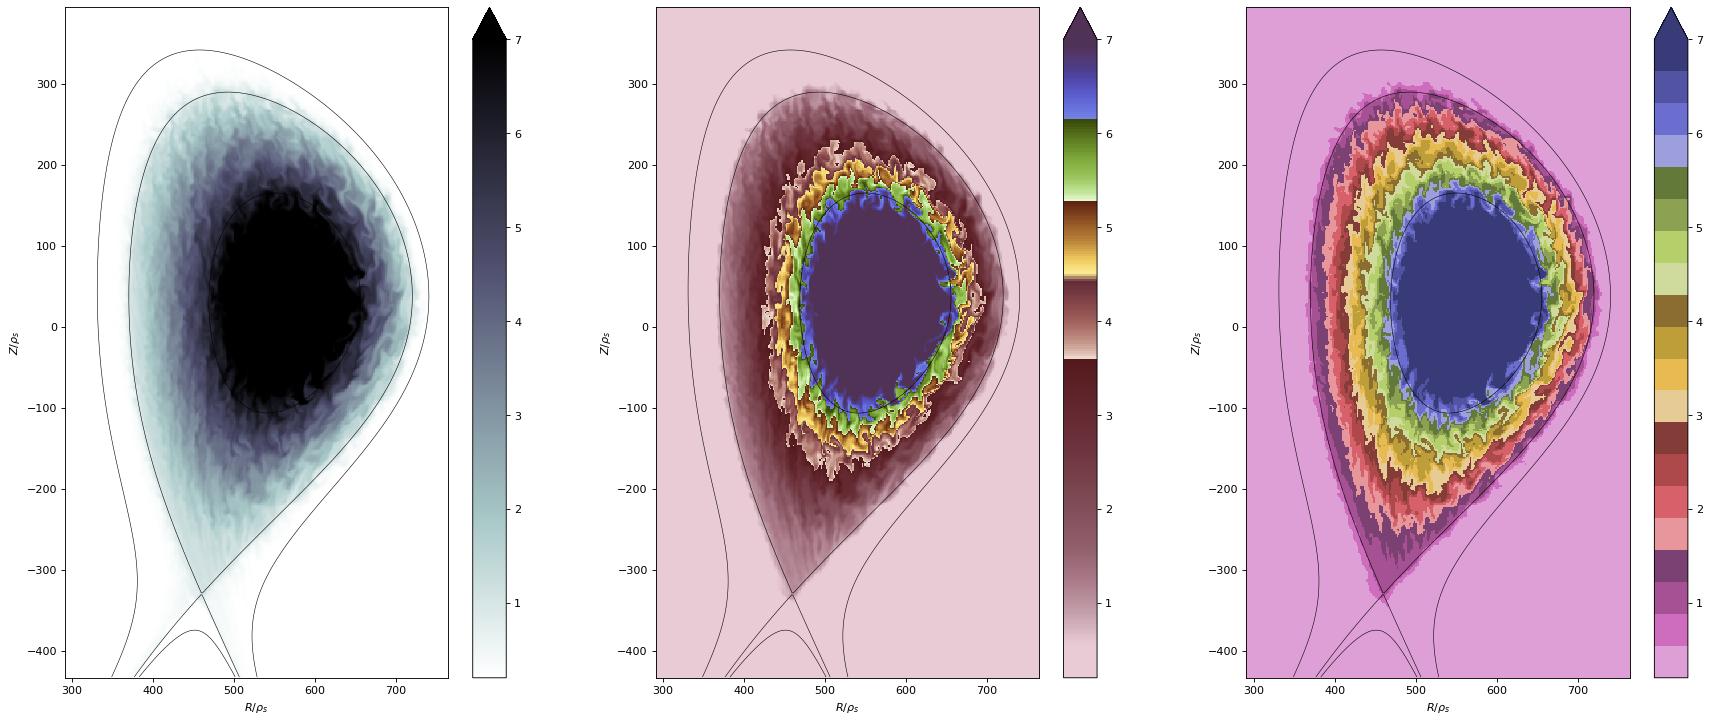

In [13]:
# dark-is-more bias
# artificially extend RAM? to plot 
# fix contours
%matplotlib inline
nrows = 1
ncols = 3
idx = 0
fig,axi=plt.subplots(nrows, ncols,figsize=(ncols*3*3,nrows*3*3.7),dpi= 80, facecolor='w', edgecolor='k')
data = da['electrons_2d'][-1,:,:]
rhop = da['Rho_p'][0,:,:]
Z = da['zc'][0,0,:,:]
for color in ['bone_r','continuous-tab20b','tab20b_r'] :
    ax = axi[idx]

    # data = np.ma.masked_where( (rhop>1.15) | (  (rhop<0.97) & (Z < -350)), data)
    # data=np.ma.masked_where( data<0.21, data)

    cmap = plt.get_cmap( color).copy()
    cmap.set_bad('white')
    # cmap.set_bad('black')
#     norm = colors.LogNorm(vmin = 0.2, vmax = 7)
#     norm = colors.TwoSlopeNorm( vmin=0.2, vcenter=1, vmax=7)
    norm = colors.Normalize( vmin = 0.2, vmax = 7)
    pcm = ax.pcolormesh( da['x'], da['y'], data,
                    norm=norm,
                    shading='auto', # more pixely
    #                 shading='gouraud',
                    cmap=cmap,
                    rasterized=True)
    im = ax.contour( da['x'], da['y'], da["Rho_p"][0,:,:],
                    levels=[1,lvls[0]], linewidths=.5,colors='k')
    im = ax.contour( da['x'], da['y'][0:50], da["Rho_p"][0,0:50,:],
                    levels=[lvls[1]], linewidths=.5,colors='k')
    im = ax.contour( da['x'], da['y'], da["Rho_p"][0,:,:],
                    levels=[da.source['damping']['boundary']], linewidths=.5,colors='k')
    ax.set_aspect('equal')
    ax.set_xlabel( r"$R/\rho_s$")
    ax.set_ylabel( r"$Z/\rho_s$")
    fig.colorbar(pcm, ax=ax, extend='max',)
    idx = idx+1
plt.show()


In [306]:
# da.feltor.animate_list(
#     variables=[da['electrons_2d'],da['Ue_2d'],da['Ui_2d'],da['vorticity_2d']],
#     aspect="equal", fps=10000
# )


# xvals = da['x']
# yvals = da['y']
# vals = da['electrons_2d'].values
# blocks = amp.blocks.Pcolormesh( xvals, yvals, vals, ax = ax,
#                                vmin = 0, vmax = 10,
#                                shading='gouraud', cmap='jet',rasterized=True)
# t_values = da["time"]/1000
# timeline = amp.Timeline( t_values, fps = 50)
# anim = amp.Animation( [blocks], timeline, fig)
# plt.show()
# anim.controls()
# anim.save_gif("test")

In [307]:
# convert to mp4 with 
#https://unix.stackexchange.com/questions/40638/how-to-do-i-convert-an-animated-gif-to-an-mp4-or-mv4-on-the-command-line
#ffmpeg -i animated.gif -movflags faststart -pix_fmt yuv420p -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" video.mp4

In [308]:
da.time.attrs['units'] = r"$\Omega_{ci}^{-1}$"
da.time

<xarray.DataArray 'time' (time: 946)>
array([    0.,   100.,   200., ..., 94300., 94400., 94500.])
Coordinates:
  * time     (time) float64 0.0 100.0 200.0 300.0 ... 9.43e+04 9.44e+04 9.45e+04
Attributes:
    units:    $\Omega_{ci}^{-1}$

<IPython.core.display.Javascript object>


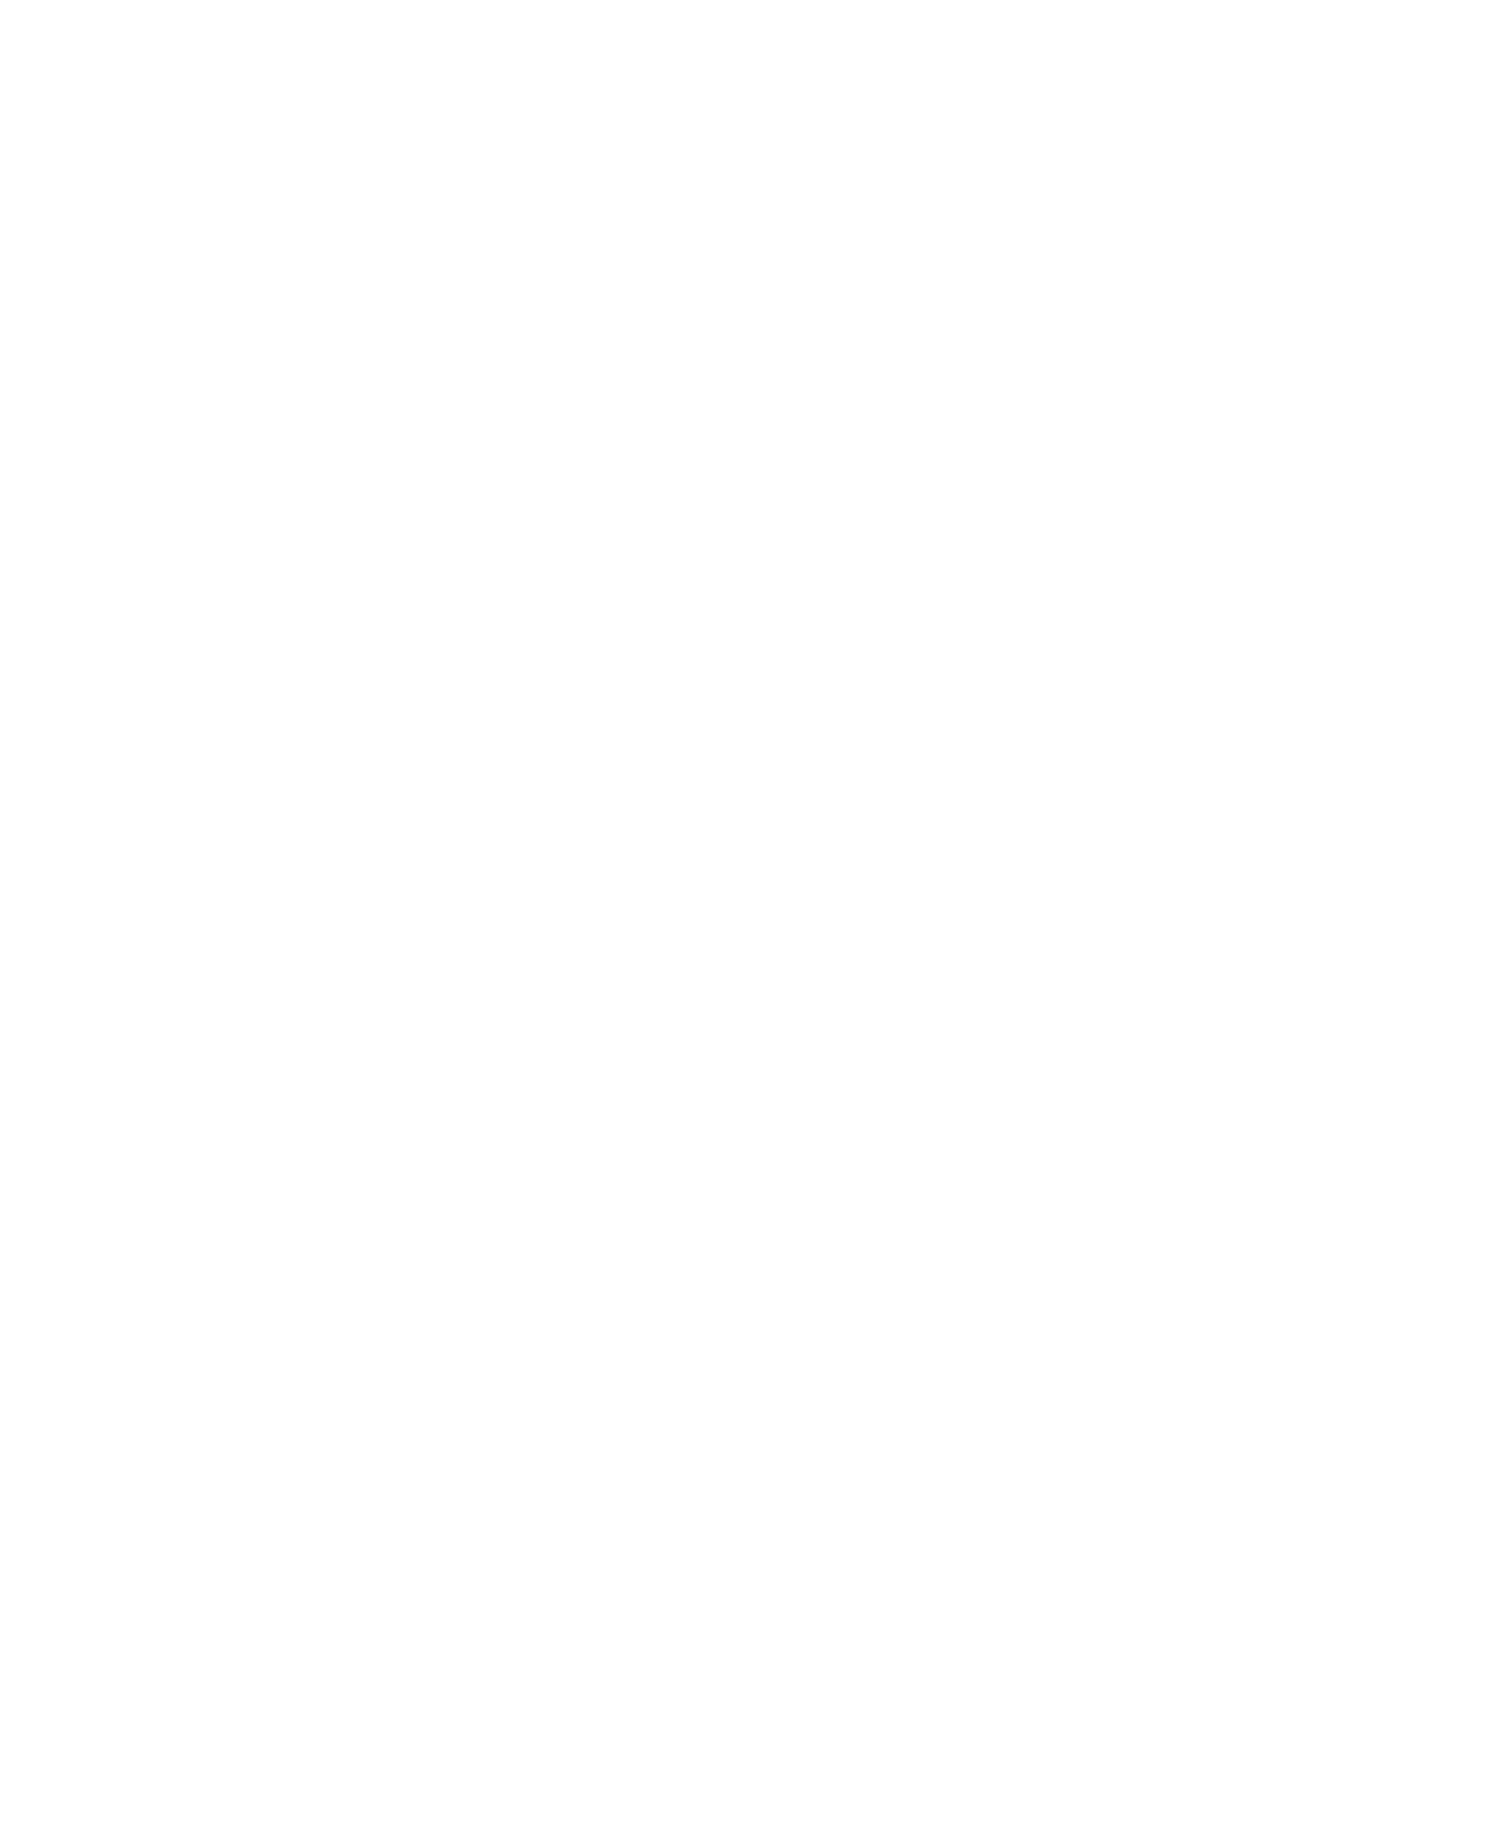

electrons_2d data passed has 3 dimensions - will use animatplot.blocks.Pcolormesh()


<IPython.core.display.Javascript object>


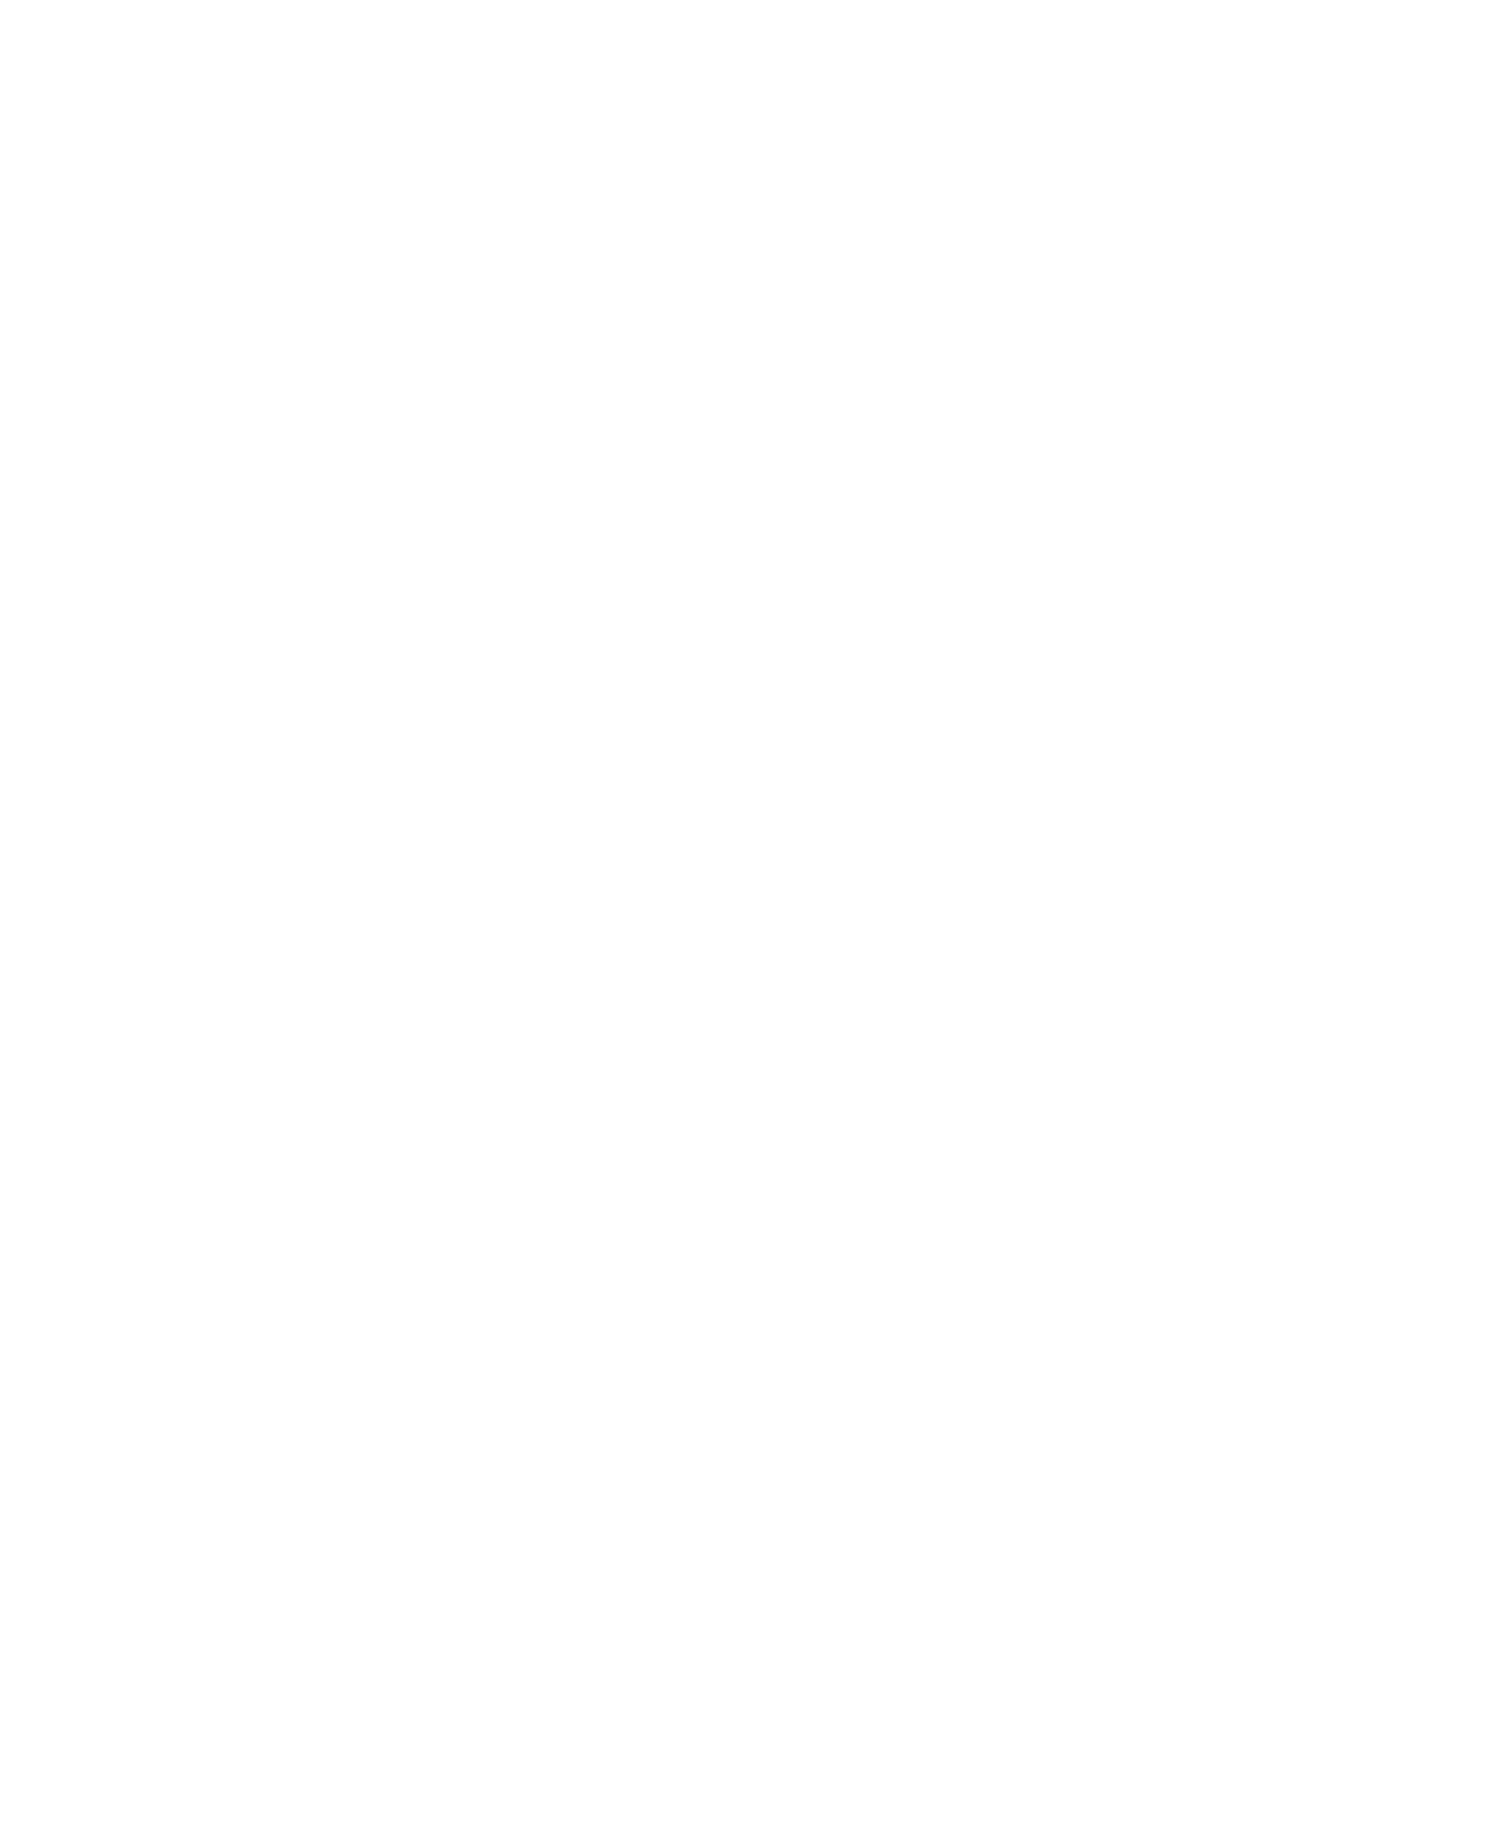

In [14]:
%matplotlib notebook
fig,ax=plt.subplots(1,1,figsize=(3*3,3*3.7),dpi= 80, facecolor='w', edgecolor='k')

# norm = colors.TwoSlopeNorm( vmin=0.2, vcenter=1, vmax=7)
# cmap = plt.get_cmap( 'continuous-tab20b').copy()
norm = colors.Normalize( vmin = 0.2, vmax = 7)
cmap = plt.get_cmap( 'bone_r').copy()
anim = da["electrons_2d"][:,:,:].feltor.animate2D(
    x="x", y="y",ax = ax, fps=50,
    shading='auto', norm=norm, cmap=cmap, extend='max', controls='timeline'
)

# print(da["Rho_p"])
im = ax.contour( da['x'], da['y'], da["Rho_p"][0,:,:],
                levels=[1,lvls[0]], linewidths=.5,colors='k')
im = ax.contour( da['x'], da['y'][0:50], da["Rho_p"][0,0:50,:],
                levels=[lvls[1]], linewidths=.5,colors='k')
im = ax.contour( da['x'], da['y'], da["Rho_p"][0,:,:],
                levels=[da.source['damping']['boundary']], linewidths=.5,colors='k')
ax.set_aspect('equal')
ax.set_xlabel( r"$R/\rho_s$")
ax.set_ylabel( r"$Z/\rho_s$")

anim.save( "ne_"+str(da.physical["resistivity"])+".gif", writer=animation.PillowWriter(fps=20))


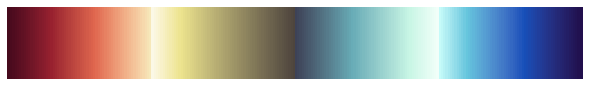

In [13]:
cmap = cm.make_cmap( 'ccc-tool_colormap_Red Purple 1 _ Yellow Orange 8 _ Blue 5 _ Blue 3.xml')
cm.plot_cmap(cmap)

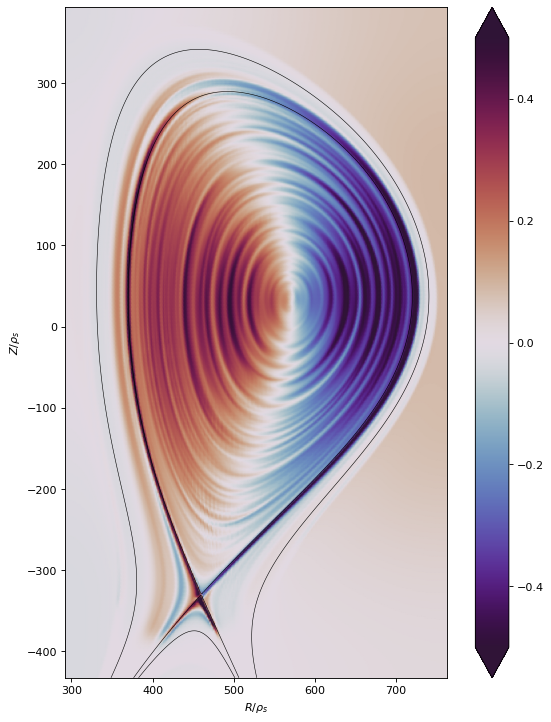

In [266]:
# Plotting Current
%matplotlib inline
fig,ax=plt.subplots(1,1,figsize=(3*3,3*3.7),dpi= 80, facecolor='w', edgecolor='k')

last_idx = np.size( da["time"])-1
cmap=plt.get_cmap('twilight_shifted')
# cmap=plt.get_cmap('seismic')
# cmap = cm.make_cmap( 'ccc-tool_colormap_Red Purple 1 _ Yellow Orange 8 _ Blue 5 _ Blue 3.xml').reversed()
# cmap = cm.make_cmap( 'ccc-tool_colormap_Divergent 1.xml')

pcm = ax.pcolormesh( da['x'], da['y'], ds['niui_cta2d'][last_idx,:,:]-ds['neue_cta2d'][last_idx,:,:],
                    vmin=-0.5,vmax=0.5,
#                 norm=colors.CenteredNorm(),
#                 norm=colors.SymLogNorm(linthresh=0.4, linscale=.1,
#                                               vmin=-0.2, vmax=0.2, base=10),
#                 shading='auto', # more pixely
                shading='gouraud',
                cmap=cmap,
              rasterized=True)
fig.colorbar(pcm, ax=ax,extend='both')
im = ax.contour( da['x'], da['y'], da["Rho_p"][0,:,:],
                levels=[1,lvls[0]], linewidths=.5,colors='k')
im = ax.contour( da['x'], da['y'][0:50], da["Rho_p"][0,0:50,:],
                levels=[lvls[1]], linewidths=.5,colors='k')
ax.set_aspect('equal')
ax.set_xlabel( r"$R/\rho_s$")
ax.set_ylabel( r"$Z/\rho_s$")
plt.show()

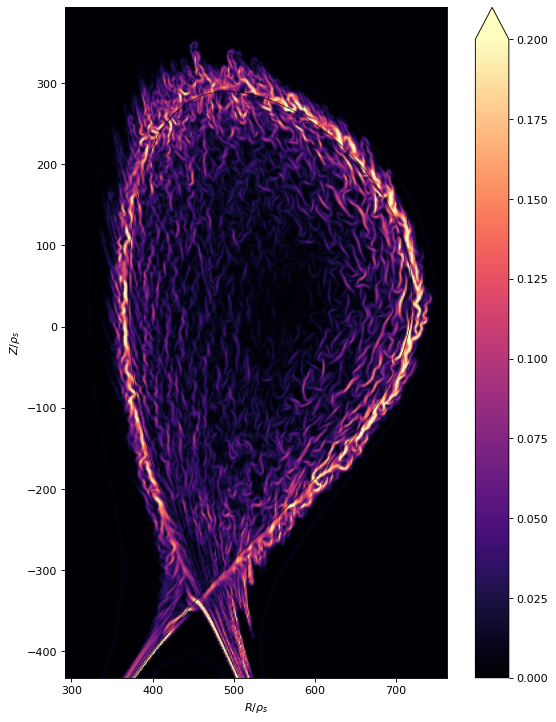

In [288]:
# Plotting Current
%matplotlib inline
fig,ax=plt.subplots(1,1,figsize=(3*3,3*3.7),dpi= 80, facecolor='w', edgecolor='k')

last_idx = np.size( da["time"])-1
cmap=plt.get_cmap('hot')
# cmap=plt.get_cmap('seismic')
# cmap = cm.make_cmap( 'ccc-tool_colormap_Red Purple 1 _ Yellow Orange 8 _ Blue 5 _ Blue 3.xml').reversed()
cmap = cm.make_cmap( 'ccc-tool_colormap_Divergent 1.xml')
cmap = plt.get_cmap( 'magma')
# pcm = ax.pcolormesh( da['x'], da['y'], ds['vorticity_cta2d'][last_idx,:,:],
pcm = ax.pcolormesh( da['x'], da['y'], da['lperpinv_2d'][last_idx,:,:],
                    vmin=0.,vmax=0.2,
#                     vmin=0,vmax=0.00051,
#                 norm=colors.CenteredNorm(),
#                 norm=colors.SymLogNorm(linthresh=0.001, linscale=.5,
#                                               vmin=-0.2, vmax=0.2, base=10),
#                 shading='auto', # more pixely
                shading='gouraud',
                cmap=cmap,
              rasterized=True)
fig.colorbar(pcm, ax=ax,extend='max')
im = ax.contour( da['x'], da['y'], da["Rho_p"][0,:,:],
                levels=[1,lvls[0]], linewidths=.5,colors='k')
im = ax.contour( da['x'], da['y'][0:50], da["Rho_p"][0,0:50,:],
                levels=[lvls[1]], linewidths=.5,colors='k')
ax.set_aspect('equal')
ax.set_xlabel( r"$R/\rho_s$")
ax.set_ylabel( r"$Z/\rho_s$")
plt.show()

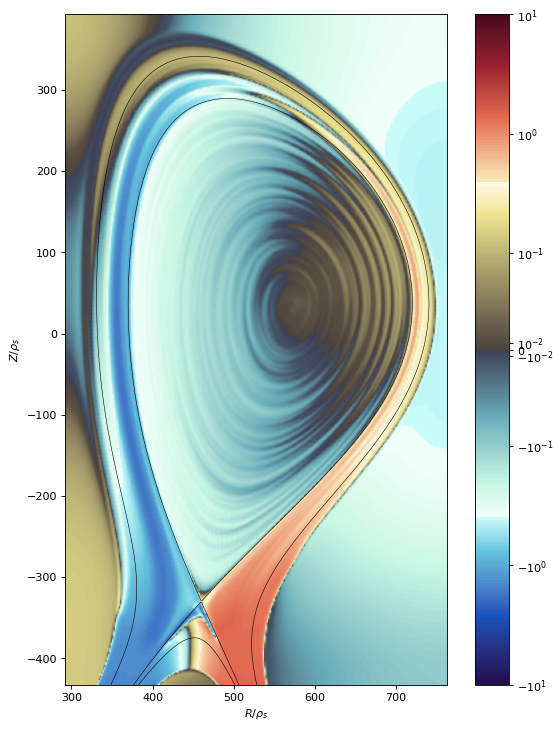

In [106]:
# Plotting Ue
%matplotlib inline
fig,ax=plt.subplots(1,1,figsize=(3*3,3*3.7),dpi= 80, facecolor='w', edgecolor='k')

last_idx = np.size( da["time"])-1
cmap = cm.make_cmap( 'ccc-tool_colormap_Divergent 1.xml')
cmap = cm.make_cmap( 'ccc-tool_colormap_Red Purple 1 _ Yellow Orange 8 _ Blue 5 _ Blue 3.xml').reversed()
pcm = ax.pcolormesh( da['x'], da['y'], ds['Ue_cta2d'][last_idx,:,:],
#                 norm=colors.CenteredNorm(),
                norm=colors.SymLogNorm(linthresh=.02, linscale=.1,
                                              vmin=-10, vmax=10, base=10),
                    
#                 shading='auto', # more pixely
                shading='gouraud',
#                 cmap='seismic',
                cmap=cmap,
              rasterized=True)
im = ax.contour( da['x'], da['y'], da["Rho_p"][0,:,:],
                levels=[1,lvls[0]], linewidths=.5,colors='k')
im = ax.contour( da['x'], da['y'][0:50], da["Rho_p"][0,0:50,:],
                levels=[lvls[1]], linewidths=.5,colors='k')
fig.colorbar(pcm, ax=ax)
ax.set_aspect('equal')
ax.set_xlabel( r"$R/\rho_s$")
ax.set_ylabel( r"$Z/\rho_s$")
plt.show()

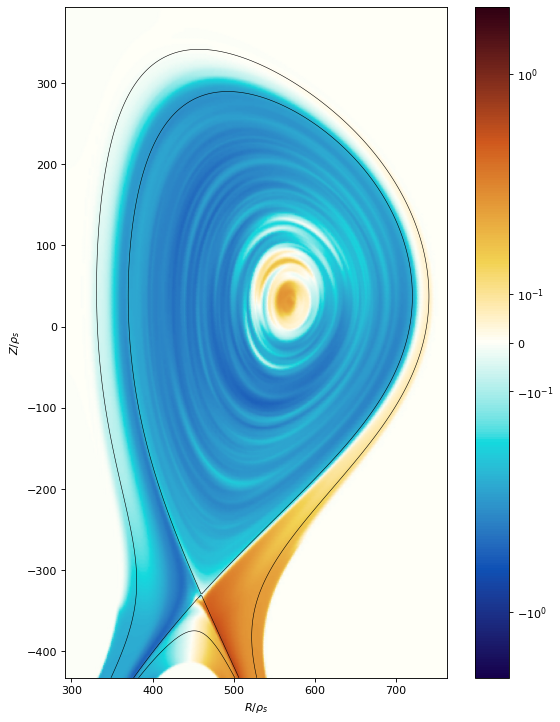

In [107]:
# Plotting NiUi
%matplotlib inline
fig,ax=plt.subplots(1,1,figsize=(3*3,3*3.7),dpi= 80, facecolor='w', edgecolor='k')

last_idx = np.size( da["time"])-1
cmap=plt.get_cmap('twilight_shifted')
# cmap=plt.get_cmap('seismic')
# cmap = cm.make_cmap( 'ccc-tool_colormap_Red Purple 1 _ Yellow Orange 8 _ Blue 5 _ Blue 3.xml').reversed()
cmap = cm.make_cmap( 'ccc-tool_colormap_Divergent 1.xml')
pcm = ax.pcolormesh( da['x'], da['y'], ds['niui_cta2d'][last_idx,:,:],
#                     vmin=-1., vmax=1.,
#                 norm=colors.CenteredNorm(),
                norm=colors.SymLogNorm(linthresh=.1, linscale=.2,
                                              vmin=-2, vmax=2, base=10),
#                 shading='auto', # more pixely
                shading='gouraud',
                cmap=cmap,
              rasterized=True)
fig.colorbar(pcm, ax=ax)
im = ax.contour( da['x'], da['y'], da["Rho_p"][0,:,:],
                levels=[1,lvls[0]], linewidths=.5,colors='k')
im = ax.contour( da['x'], da['y'][0:50], da["Rho_p"][0,0:50,:],
                levels=[lvls[1]], linewidths=.5,colors='k')
ax.set_aspect('equal')
ax.set_xlabel( r"$R/\rho_s$")
ax.set_ylabel( r"$Z/\rho_s$")
plt.show()

0.0001


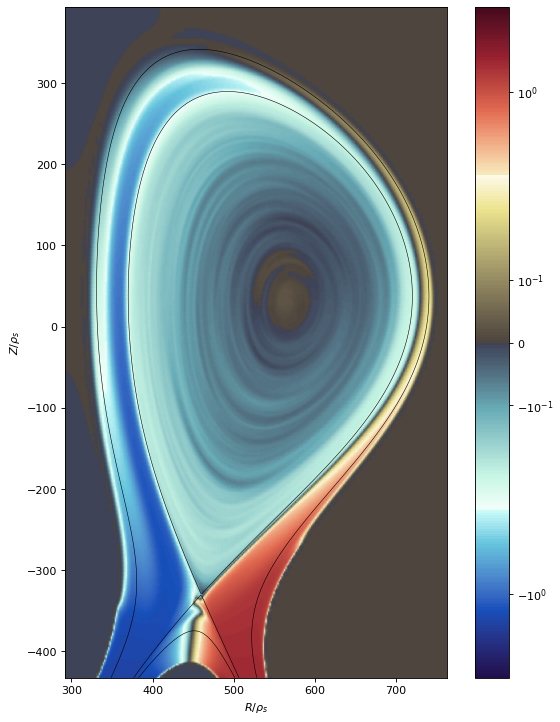

In [108]:
# Plotting Ui
%matplotlib inline
fig,ax=plt.subplots(1,1,figsize=(3*3,3*3.7),dpi= 80, facecolor='w', edgecolor='k')

last_idx = np.size( da["time"])-1
cmap = cm.make_cmap( 'ccc-tool_colormap_Red Purple 1 _ Yellow Orange 8 _ Blue 5 _ Blue 3.xml').reversed()
pcm = ax.pcolormesh( da['x'], da['y'], ds['Ui_cta2d'][last_idx,:,:],
#                 norm=colors.CenteredNorm(),
                norm=colors.SymLogNorm(linthresh=.1, linscale=.3,
                                              vmin=-2.8, vmax=2.8, base=10),
                    
#                 shading='auto', # more pixely
                shading='gouraud',
                cmap=cmap,
              rasterized=True)
im = ax.contour( da['x'], da['y'], da["Rho_p"][0,:,:],
                levels=[1,lvls[0]], linewidths=.5,colors='k')
im = ax.contour( da['x'], da['y'][0:50], da["Rho_p"][0,0:50,:],
                levels=[lvls[1]], linewidths=.5,colors='k')
fig.colorbar(pcm, ax=ax)
ax.set_aspect('equal')
ax.set_xlabel( r"$R/\rho_s$")
ax.set_ylabel( r"$Z/\rho_s$")
print(da.physical["resistivity"])
plt.show()

<xarray.DataArray 'time' ()>
array(100.)
0.0001


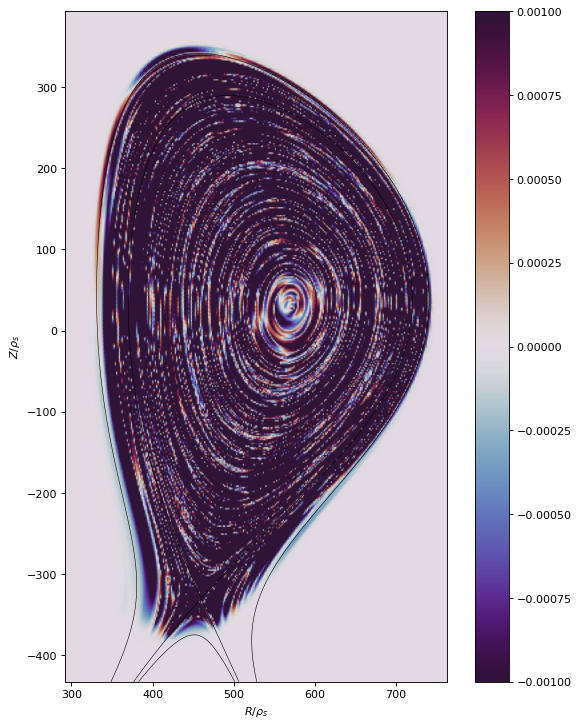

In [113]:
# Plotting NiUi
%matplotlib inline
fig,ax=plt.subplots(1,1,figsize=(3*3,3*3.7),dpi= 80, facecolor='w', edgecolor='k')

last_idx = np.size( da["time"])-1
pcm = ax.pcolormesh( da['x'], da['y'],
#                     (da['sparsni_tt_2d'][last_idx,:,:]-da['Ui_2d'][last_idx,:,:]*da['sni_tt_2d'][last_idx,:,:])/da['ions_2d'][last_idx,:,:]
                    (ds['Ui_cta2d'][last_idx,:,:]-ds['Ui_cta2d'][last_idx-1,:,:])
                    +ds['Ui_cta2d'][last_idx-1,:,:]*ds['sni_tt_cta2d'][last_idx,:,:]/ds['ions_cta2d'][last_idx,:,:]
#                     da['Ui_2d'][last_idx,:,:]/da['ions_2d'][last_idx,:,:]
#                     (da['ions_2d'][last_idx,:,:]-da['ions_2d'][last_idx-1,:,:])/100
#                     -da['sni_tt_2d'][last_idx,:,:]/100
                    ,
                vmin=-1e-3,vmax=1e-3,
#                 shading='auto', # more pixely
                shading='gouraud',
#                 cmap='seismic',
                cmap='twilight_shifted',
              rasterized=True)
print((da['time'][last_idx]-da['time'][last_idx-1]))
im = ax.contour( da['x'], da['y'], da["Rho_p"][0,:,:],
                levels=[1,lvls[0]], linewidths=.5,colors='k')
im = ax.contour( da['x'], da['y'][0:50], da["Rho_p"][0,0:50,:],
                levels=[lvls[1]], linewidths=.5,colors='k')
fig.colorbar(pcm, ax=ax)
ax.set_aspect('equal')
ax.set_xlabel( r"$R/\rho_s$")
ax.set_ylabel( r"$Z/\rho_s$")
print(da.physical["resistivity"])
plt.show()

<IPython.core.display.Javascript object>


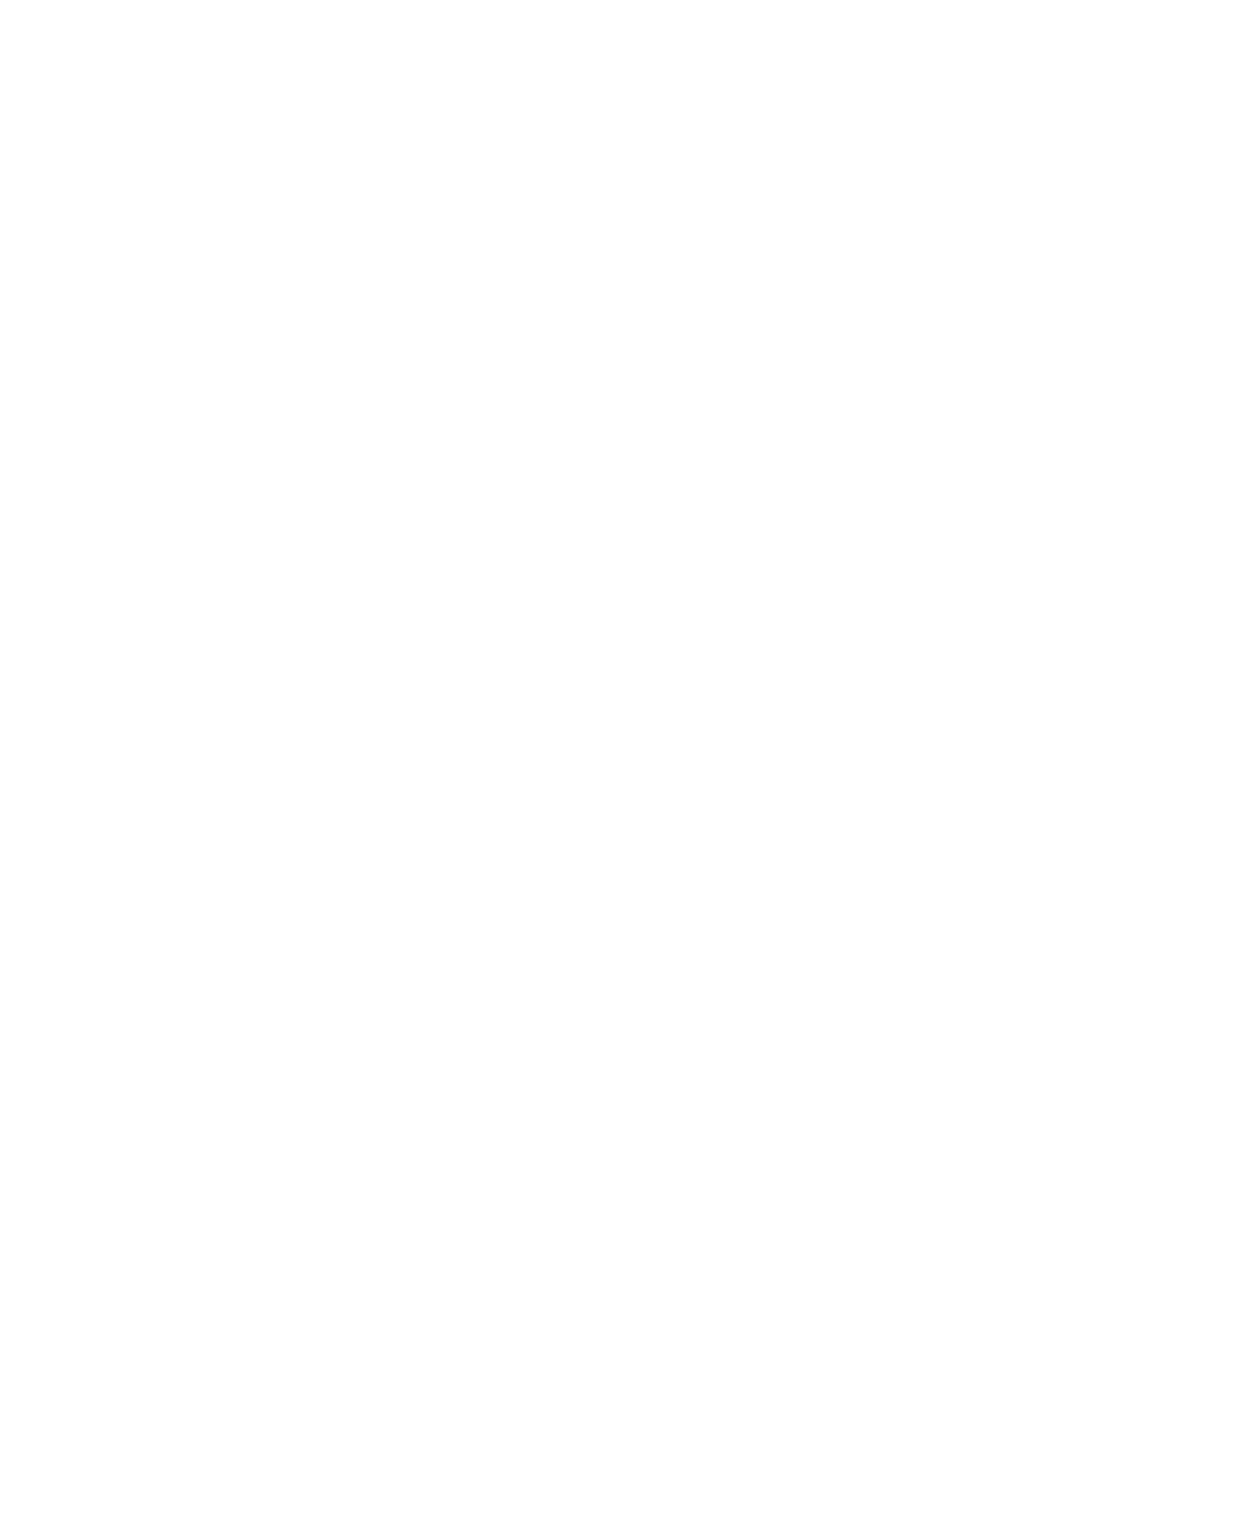

Ui_2d data passed has 3 dimensions - will use animatplot.blocks.Pcolormesh()


<IPython.core.display.Javascript object>


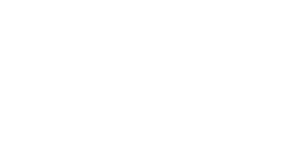

In [44]:
%matplotlib notebook
fig,ax=plt.subplots(1,1,figsize=(3*3,3*3.7),dpi= 80, facecolor='w', edgecolor='k')


anim = da["Ui_2d"][:,:,:].feltor.animate2D(x="x", y="y",ax = ax, fps=50,
                                          #                 norm=colors.CenteredNorm(),
                norm=colors.SymLogNorm(linthresh=.01, linscale=.1,
                                              vmin=-2, vmax=2, base=10),
                    
                shading='auto', # more pixely
#                 shading='gouraud',
#                 cmap='seismic',
                cmap='twilight_shifted',
              rasterized=True)
# print(da["Rho_p"])
im = ax.contour( da['x'], da['y'], da["Rho_p"][0,:,:],
                levels=[1,lvls[0]], linewidths=.5,colors='k')
im = ax.contour( da['x'], da['y'][0:50], da["Rho_p"][0,0:50,:],
                levels=[lvls[1]], linewidths=.5,colors='k')
ax.set_aspect('equal')
ax.set_xlabel( r"$R/\rho_s$")
ax.set_ylabel( r"$Z/\rho_s$")

anim.save( "ui_"+str(da.physical["resistivity"])+".gif", writer=animation.PillowWriter(fps=20))

<IPython.core.display.Javascript object>


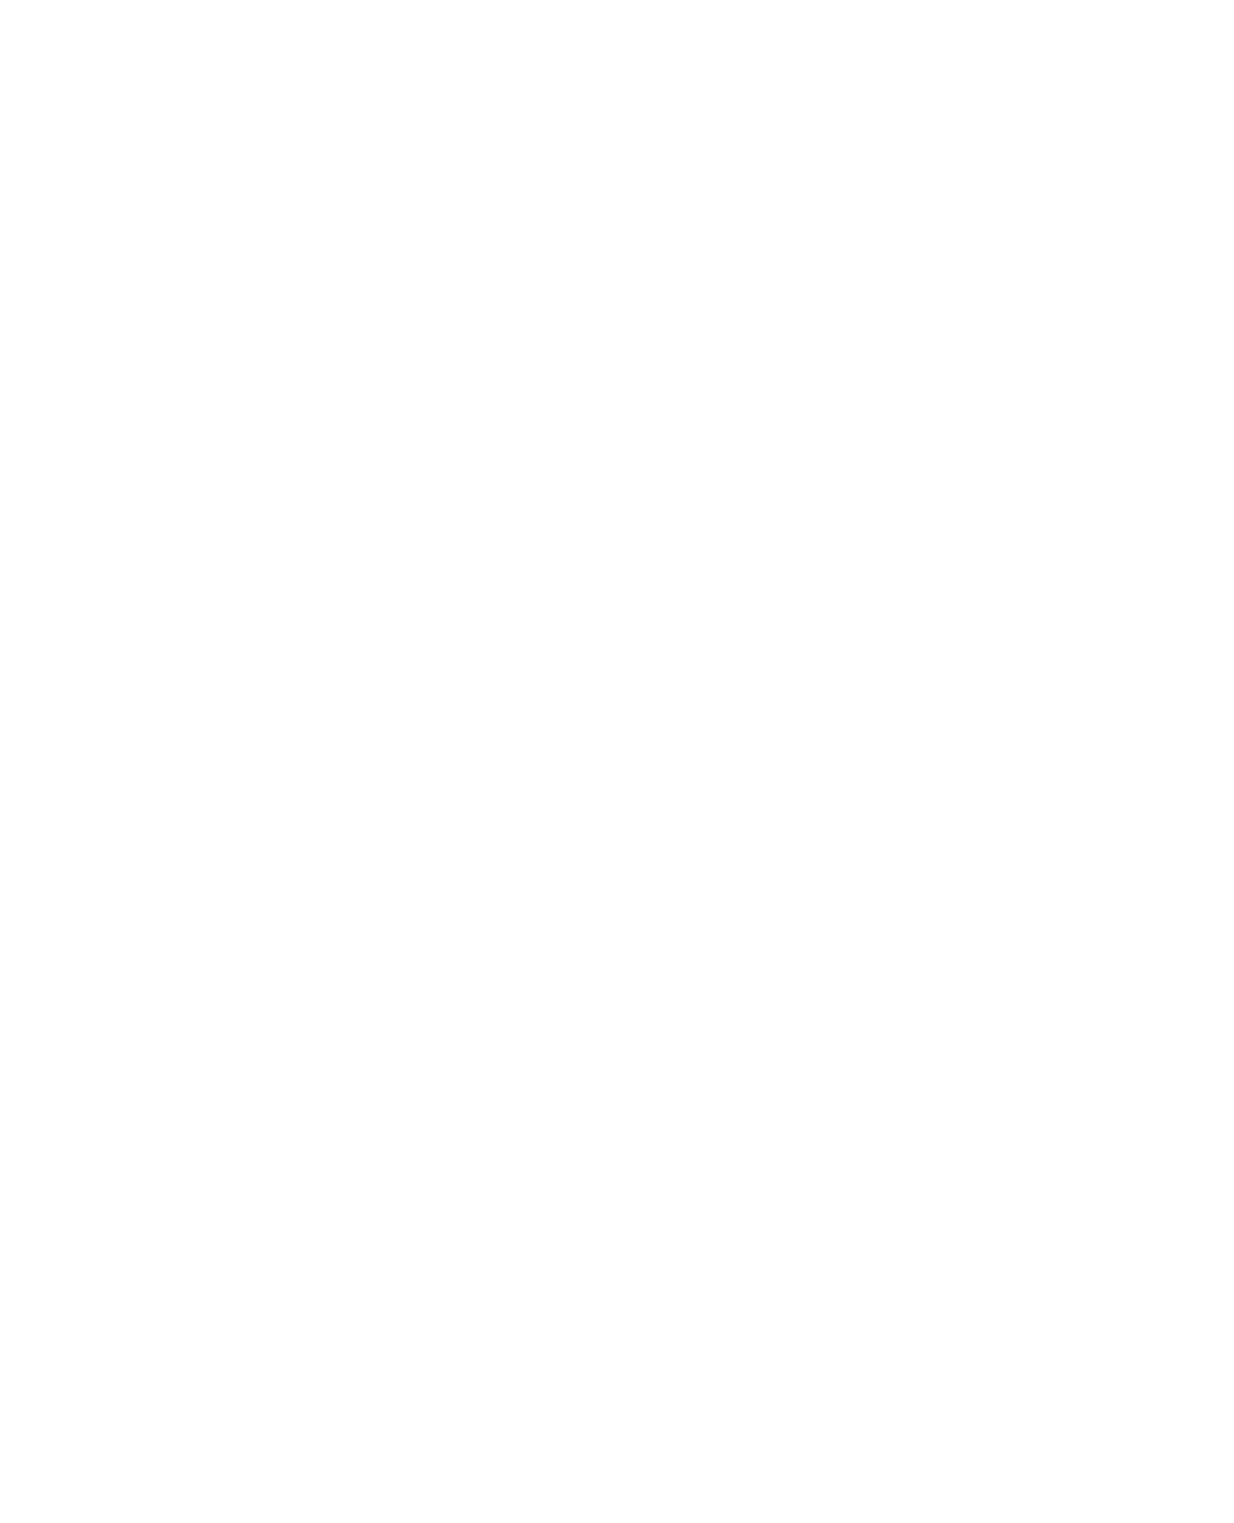

Ue_2d data passed has 3 dimensions - will use animatplot.blocks.Pcolormesh()


<IPython.core.display.Javascript object>


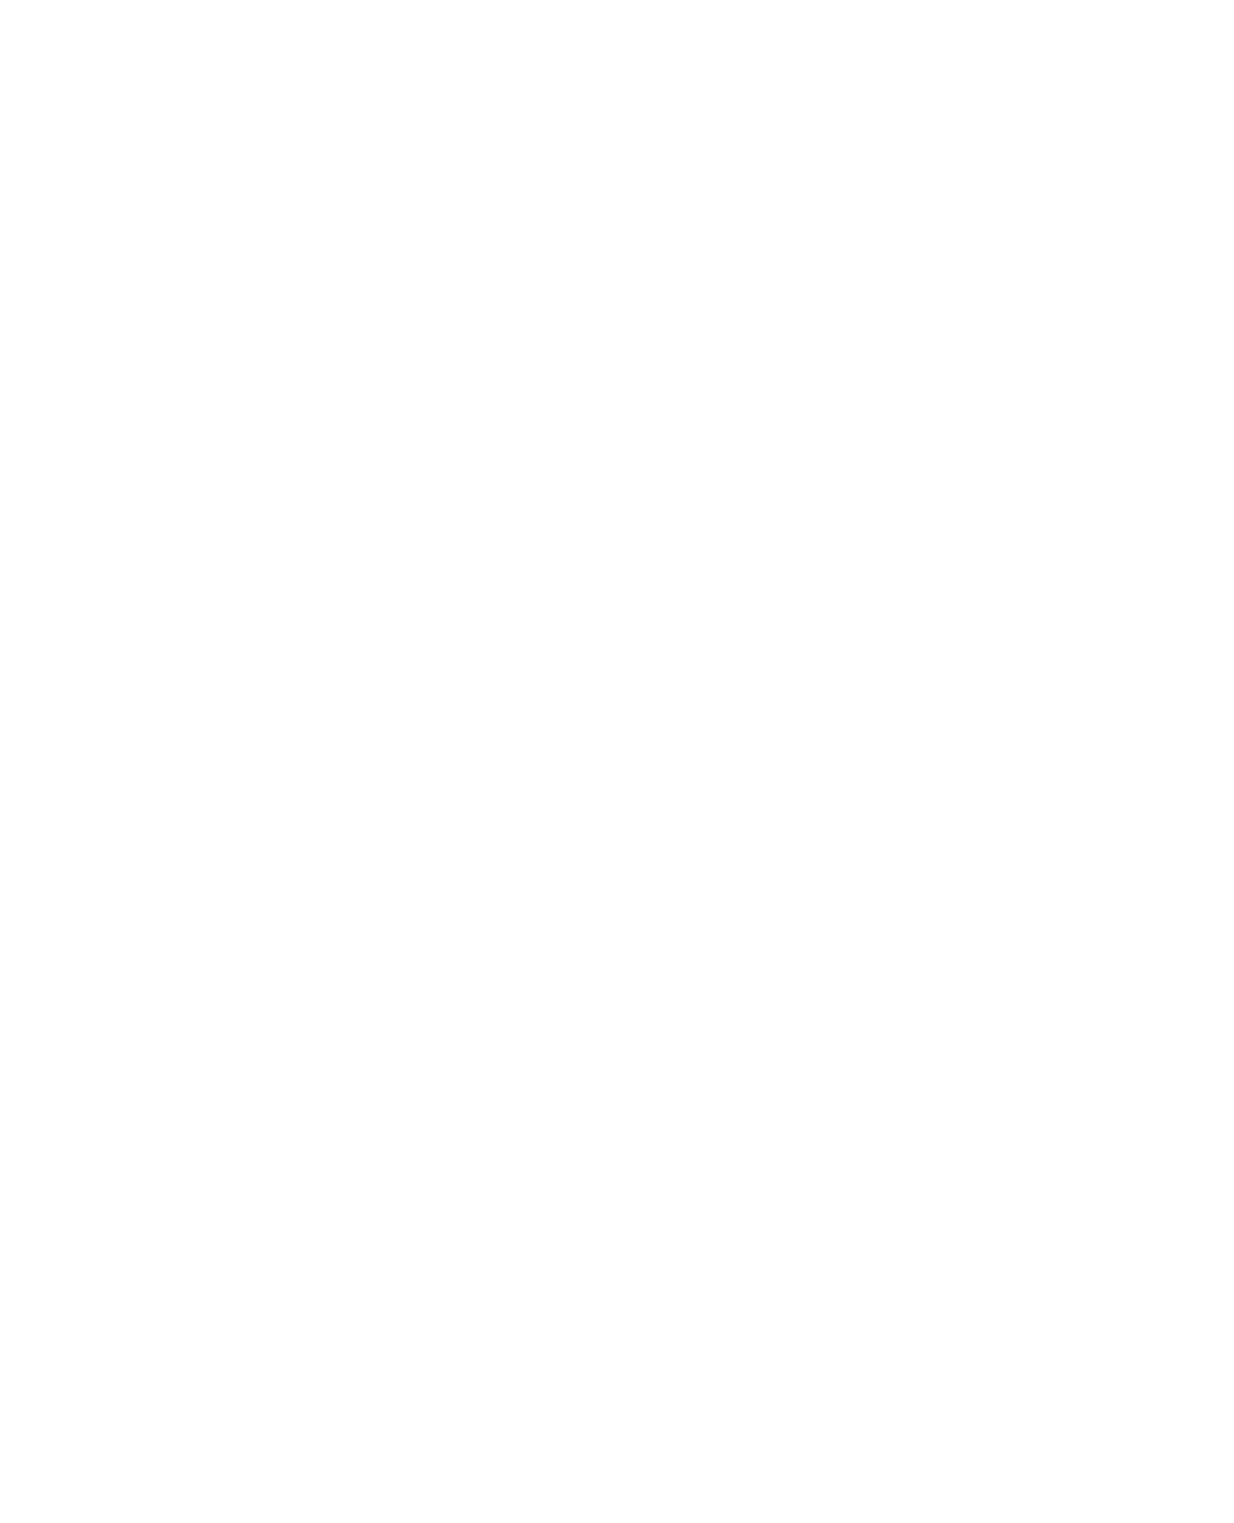

In [70]:
%matplotlib notebook
fig,ax=plt.subplots(1,1,figsize=(3*3,3*3.7),dpi= 80, facecolor='w', edgecolor='k')


anim = da["Ue_2d"][:,:,:].feltor.animate2D(x="x", y="y",ax = ax, fps=50,
                norm=colors.SymLogNorm(linthresh=.02, linscale=.1,
                                              vmin=-10, vmax=10, base=10),
                    
                shading='auto', # more pixely
#                 shading='gouraud',
#                 cmap='seismic',
                cmap='twilight_shifted',
              rasterized=True)
# print(da["Rho_p"])
im = ax.contour( da['x'], da['y'], da["Rho_p"][0,:,:],
                levels=[1,lvls[0]], linewidths=.5,colors='k')
im = ax.contour( da['x'], da['y'][0:50], da["Rho_p"][0,0:50,:],
                levels=[lvls[1]], linewidths=.5,colors='k')
ax.set_aspect('equal')
ax.set_xlabel( r"$R/\rho_s$")
ax.set_ylabel( r"$Z/\rho_s$")

anim.save( "ue_"+str(da.physical["resistivity"])+".gif", writer=animation.PillowWriter(fps=20))